In [1]:
import numpy as np
from torchvision.datasets import VOCDetection
import cv2
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch.nn.functional as F
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from bs4 import BeautifulSoup

## 0. Dataset
- 학습할 데이터터셋으로 VOCDetection2007 활용
- 각 image 별로 size가 다르기 때문에 800*800 크기로 resize 시켜줌
- 총 20개의 class를 가지고 있으며 xml 구조를 띄고 있기 때문에 annotation 과 image를 분리하여 dataset 생성


In [2]:
dataset = VOCDetection('.\VOCDetection',year='2007',image_set = "trainval", download=True)

Using downloaded and verified file: .\VOCDetection\VOCtrainval_06-Nov-2007.tar
Extracting .\VOCDetection\VOCtrainval_06-Nov-2007.tar to .\VOCDetection


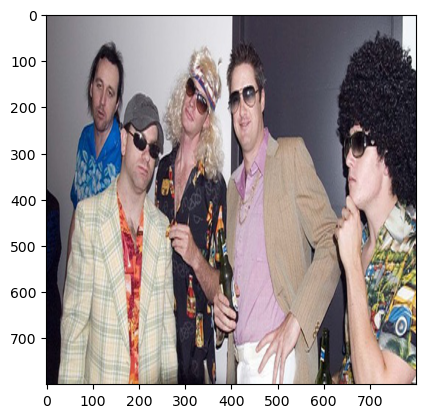

In [3]:
img,target = dataset.__getitem__(99)
img_resized = img.resize((800,800))
img_resized = np.array(img_resized)
plt.imshow(img_resized)

In [4]:
y_scale = 800/np.array(img).shape[0]
x_scale = 800/np.array(img).shape[1]

annotations = target['annotation']['object']
bndboxes = np.zeros((len(annotations),4))
for n,obj in enumerate(annotations):
    bndboxes[n,0] = int(int(obj['bndbox']['xmin'])*x_scale)
    bndboxes[n,1] = int(int(obj['bndbox']['ymin'])*y_scale)
    bndboxes[n,2] = int(int(obj['bndbox']['xmax'])*x_scale)
    bndboxes[n,3] = int(int(obj['bndbox']['ymax'])*y_scale)

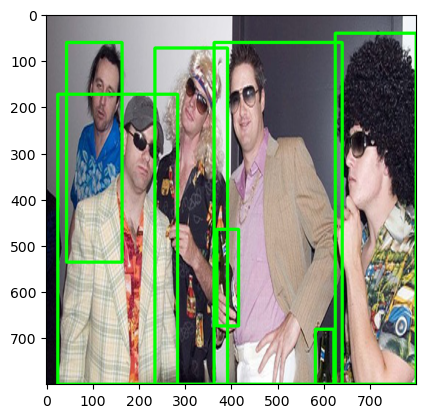

In [5]:
img_clone = np.copy(img_resized)
for i in range(len(bndboxes)):
    cv2.rectangle(img_clone, (int(bndboxes[i][0]), int(bndboxes[i][1])), (int(bndboxes[i][2]), int(bndboxes[i][3])), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

In [6]:
voc_annotation_dir = './VOCDetection/VOCdevkit/VOC2007/Annotations/'
voc_jpeg_dir = './VOCDetection/VOCdevkit/VOC2007/JPEGImages/'

train_path = './VOCDetection/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
val_path = './VOCDetection/VOCdevkit/VOC2007/ImageSets/Main/val.txt'

In [7]:
classes = 'person, bird, cat, cow, dog, horse, sheep, aeroplane, bicycle, boat, bus, car, motorbike, train, bottle, chair, dining table, potted plant, sofa, tv/monitor'
classes = classes.split(', ')
class_dict = dict(zip(classes,range(len(classes))))

In [8]:
def parse_train_val(data_path):
    samples = []

    with open(data_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            res = line.strip().split(' ')
            samples.append(res[0])

    return np.array(samples)

def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    label = obj.find('name').text
    num = class_dict[label]
    return num

def generate_target(path): 
    with open(path,'r') as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

In [9]:
class CustomDataset(Dataset):
    def __init__(self,transforms,path):
        self.path = path
        self.samples = {'train': parse_train_val(train_path), 'val': parse_train_val(val_path)}
        self.transforms = transforms
        
    def __getitem__(self,idx):
        voc_annotation_dir = self.path+'Annotations/'
        voc_jpeg_dir = self.path+'/JPEGImages/'
        train_path = self.path+'ImageSets/Main/train.txt'
        val_path = self.path+'ImageSets/Main/val.txt'

        img_path = os.path.join(voc_jpeg_dir+str(self.samples['train'][idx])+'.jpg')
        target_path = os.path.join(voc_annotation_dir+str(self.samples['train'][idx])+'.xml')
        img = Image.open(img_path).convert("RGB")
        target = generate_target(target_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.samples)

def collate_fn(batch):
    return tuple(zip(*batch))


In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(800,800)),
    transforms.ToTensor()
])

In [11]:
data_path = './VOCDetection/VOCdevkit/VOC2007/'

In [12]:
custom_dataset = CustomDataset(data_transform,data_path)

In [13]:
dataloader = DataLoader(custom_dataset, batch_size=2,shuffle=False,collate_fn = collate_fn)

In [14]:
img_tensor = next(iter(dataloader))[0][0]

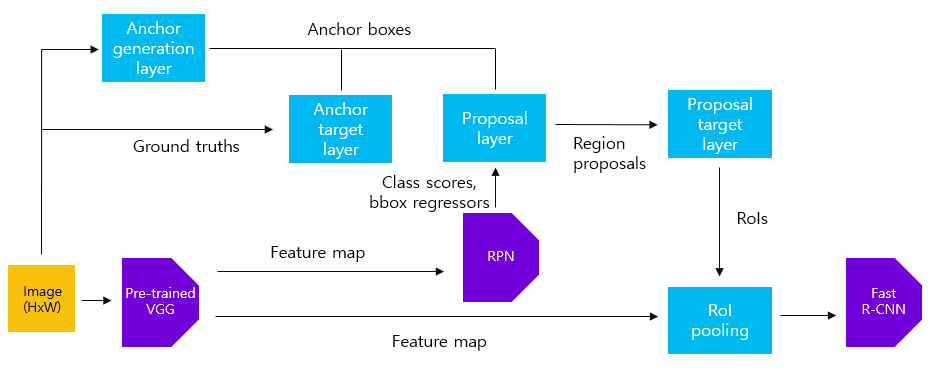

## 1. Feature Extraction
- 논문에 따라서 VGG16을 feature map extracter로 활용
- VGG16의 모든 layer를 활용하는 것이 아닌 50*50 size의 feature map을 생성할 때 까지의 layer만 활용
- 그 결과 512 * 50 * 50 의 feature map 생성

In [15]:
import torchvision
import torch
import torch.nn as nn
from torch import optim

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
model = torchvision.models.vgg16(pretrained=True).to(device)

C:\Users\c\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\c\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
def vgg16_tuning(model,device):
    model = model.to(device)
    features = list(model.features)

    dummy_img = torch.zeros((2,3,800,800)).float() #image 크기와 동일한 실험용 tensor 생성
    
    output = dummy_img.clone().to(device)
    req_features = []
    for feature in features:
        output = feature(output)
        if output.size()[2]<800//16: #VGG16이 50*50 feature map을 만들 때 까지만 학습
            break
        req_features.append(feature)
        
    return req_features

In [19]:
req_features = vgg16_tuning(model,device)

In [20]:
img_tensor = img_tensor.to(device) #이건 train 단계에서 해줘야함.
faster_rcnn_feature_extracter = nn.Sequential(*req_features) 
output_map = faster_rcnn_feature_extracter(img_tensor) #50*50 의 image feature map 생성

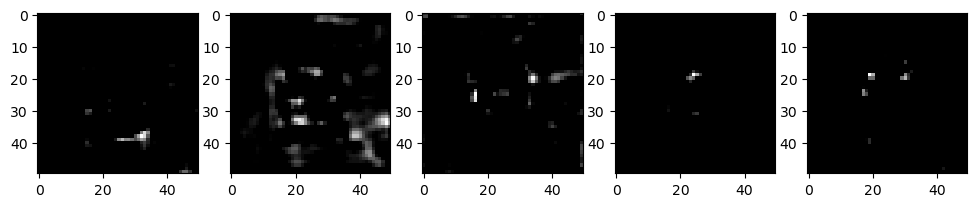

In [21]:
# visualize the first 5 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy()
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

## 2. Anchor Generation Layer
- 이미지별로 Anchor Box들을 만들어주는 단계
- feature map의 각 칸의 가운데를 중심으로 3개의 ratio, 3개의 scale을 조합하여 총 9개의 Anchor Box를 생성
-

In [22]:
def anchor_generate(image_size=800, feature_map_size=50):
    anchor_center = np.arange(16, (feature_map_size + 1) * 16, 16) - 16/2
    
    anchor_ratio = [[1,1],[1,2],[2,1]]
    anchor_scale = [128*128,256*256,512*512]
    anchor_boxes = np.zeros(((feature_map_size * feature_map_size * 9), 4))
    
    index=0
    for x in anchor_center:
        for y in anchor_center:
            for i in anchor_ratio:
                for j in anchor_scale:
                    h,w = np.sqrt(j/(i[0]*i[1]))*i[0],np.sqrt(j/(i[0]*i[1]))*i[1]
                    
                    anchor_boxes[index, 1] = y - h / 2.
                    anchor_boxes[index, 0] = x - w / 2.
                    anchor_boxes[index, 3] = y + h / 2.
                    anchor_boxes[index, 2] = x + w / 2.
                    index += 1
    return anchor_boxes
    

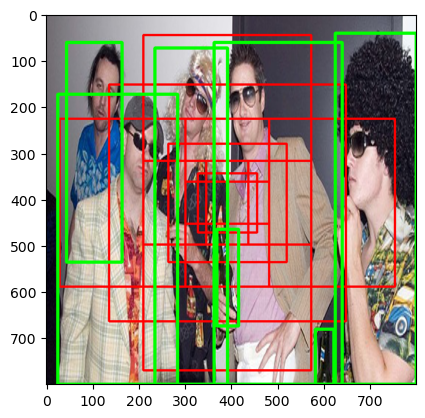

In [23]:
img_clone = np.copy(img_resized)
anchors = anchor_generate(800,50)
# draw random anchor boxes
for i in range(11025, 11034):
    x1 = int(anchors[i][0])
    y1 = int(anchors[i][1])
    x2 = int(anchors[i][2])
    y2 = int(anchors[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bndboxes)):
    cv2.rectangle(img_clone, (int(bndboxes[i][0]), int(bndboxes[i][1])), (int(bndboxes[i][2]), int(bndboxes[i][3])), color=(0, 255, 0), thickness=5)

plt.imshow(img_clone)
plt.show()

In [24]:
def inside_anchor(anchor_boxes):
    index_inside = np.where(
        (anchor_boxes[:,0]>=0) &
        (anchor_boxes[:,1]>=0) &
        (anchor_boxes[:,2]<=800) &
        (anchor_boxes[:,3]<=800))[0]
    
    valid_anchor_boxes = anchor_boxes[index_inside]

    return valid_anchor_boxes,index_inside

In [25]:
valid_anchor_boxes,index_inside = inside_anchor(anchors)

## 3. Anchor Target Layer
- RPN을 학습하기 위해 Anchor Box들에게 Target 값 부여
- 실제 Bounding Box와 IOUS를 기준으로 0.7이상이면 positive(1), 0.3이하이면 negative(0), 그 외는 학습하지 않음(-1)
- RPN에서는 image와 anchor box를 주고, 이 anchor box의 object 포함 여부(binary classification)와 Object location(Regression)을 학습하고 예측한다.

In [26]:
def ious(anchor_boxes,bndboxes):
    IOUS = np.zeros((len(anchor_boxes),len(bndboxes)))
    boxes=[]

    for i,rect in enumerate(anchor_boxes):
        rx_min,ry_min,rx_max,ry_max = rect
        for j,bndbox in enumerate(bndboxes):
            bx_min,by_min,bx_max,by_max = bndbox
            x_left = max(rx_min,bx_min)
            x_right = min(rx_max,bx_max)
            y_bottom = max(ry_min,by_min)
            y_top = min(ry_max,by_max)
        
            if x_right < x_left or y_top < y_bottom:
                iou = 0.0
                pass
            else:
                intersection_size = (x_right-x_left)*(y_top-y_bottom)
                rect_size = (rx_max-rx_min)*(ry_max-ry_min)
                bndbox_size = (bx_max-bx_min)*(by_max-by_min)
            
                iou = intersection_size / (rect_size+bndbox_size-intersection_size)
                if iou<0:
                    print(rect,bndbox,iou)
            assert iou >= 0.0
            assert iou <= 1.0
            IOUS[i,j] = iou
            boxes.append((rect,bndbox))
    return IOUS,boxes

In [27]:
annotations = target['annotation']['object']
bndboxes = np.zeros((len(annotations),4))
for n,obj in enumerate(annotations):
    bndboxes[n,0] = int(int(obj['bndbox']['xmin'])*x_scale)
    bndboxes[n,1] = int(int(obj['bndbox']['ymin'])*y_scale)
    bndboxes[n,2] = int(int(obj['bndbox']['xmax'])*x_scale)
    bndboxes[n,3] = int(int(obj['bndbox']['ymax'])*y_scale)

In [28]:
IOUS, boxes = ious(valid_anchor_boxes,bndboxes)

In [29]:
# IOUS를 기준으로 Training Anchor Box의 Target 라벨링
def make_label(ious,pos_iou_threshold=0.7,neg_iou_threshold=0.3):
    label = np.empty(len(ious),)
    label.fill(-1)
    #ious에 의해 labeling
    label[np.where(ious.max(axis=1)>=pos_iou_threshold)]=1
    label[np.where(ious.max(axis=1)<neg_iou_threshold)]=0
    label[ious.argmax(axis=0)]=1
    return label

In [30]:
# IOUS가 0.7 이상인 Anchor Box를 기준으로 Regression의 Target 생성
def make_ground_truth(IOUS,pos_iou_threshold=0.7):
    gt_box_loc = np.empty((len(IOUS),4))
    gt_box_loc.fill(-1)
    #ground_truth
    gt_box_loc[np.where(IOUS>=pos_iou_threshold)[0]] = bndboxes[np.where(IOUS>=pos_iou_threshold)[1]]
    gt_box_loc[IOUS.argmax(axis=0)] = bndboxes[IOUS[IOUS.argmax(axis=0)].argmax(axis=1)]
    return gt_box_loc

In [31]:
# RPN에는 Image와 Anchor Box들의 위치 정보, Anchor Box들의 Label, Object를 포함하는 Anchor Box들의 위치정보가 활용된다.
def make_rpn_input(anchor_boxes,valid_anchor_boxes,index_inside,label,gt_box_loc):
    # anchor label
    anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
    anchor_labels.fill(-1)
    anchor_labels[index_inside] = label
    # anchor location
    anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=valid_anchor_boxes.dtype)
    anchor_locations.fill(0)
    anchor_locations[index_inside, :] = valid_anchor_boxes
    # ground_truth
    ground_truth_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=gt_box_loc.dtype)
    ground_truth_locations.fill(0)
    ground_truth_locations[index_inside, :] = gt_box_loc
    return anchor_labels,anchor_locations,ground_truth_locations

In [32]:
label = make_label(IOUS)
gt_box_loc = make_ground_truth(IOUS)

In [33]:
anchor_labels,anchor_locations,ground_truth_locations = make_rpn_input(anchors,valid_anchor_boxes,index_inside,label,gt_box_loc)

In [34]:
anchor_boxes = anchors

In [65]:
IOUS[pos_index]

array([[0.54929693, 0.23517834, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.21690223, 0.59744516, 0.32692967, 0.00314182, 0.        ,
        0.        , 0.        ],
       [0.        , 0.0806155 , 0.46273541, 0.05588931, 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.09283994, 0.05008627, 0.        ,
        0.        , 0.48069749],
       [0.        , 0.01284711, 0.27676476, 0.71284364, 0.02253092,
        0.01352439, 0.03747177],
       [0.        , 0.01319594, 0.28492781, 0.73913833, 0.02253092,
        0.01599356, 0.03747177],
       [0.        , 0.        , 0.23021121, 0.72622883, 0.05414786,
        0.01352439, 0.03747177],
       [0.        , 0.        , 0.23674658, 0.75323438, 0.05414786,
        0.01599356, 0.03747177],
       [0.        , 0.        , 0.18693311, 0.72622883, 0.0877824 ,
        0.01352439, 0.03747177],
       [0.        , 0.        , 0.19204808, 0.75323438, 0.0877824 ,
        0.01599356, 0.0

In [35]:
pos_index = np.where(label == 1)[0]

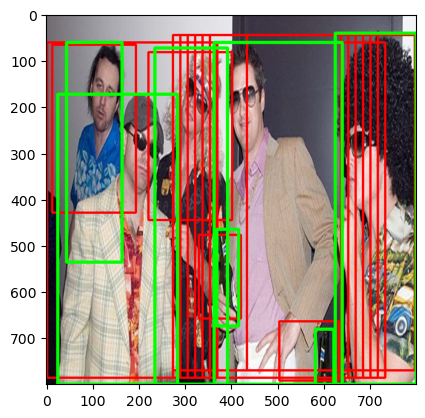

In [66]:
img_clone = np.copy(img_resized)
anchors = anchor_generate(800,50)
# draw random anchor boxes
for i in pos_index:
    x1 = int(valid_anchor_boxes[i][0])
    y1 = int(valid_anchor_boxes[i][1])
    x2 = int(valid_anchor_boxes[i][2])
    y2 = int(valid_anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bndboxes)):
    cv2.rectangle(img_clone, (int(bndboxes[i][0]), int(bndboxes[i][1])), (int(bndboxes[i][2]), int(bndboxes[i][3])), color=(0, 255, 0), thickness=5)

plt.imshow(img_clone)
plt.show()

In [36]:
        
        n_sample = 256
        pos_ratio = 0.5
        n_pos = pos_ratio * n_sample
        
        pos_index = np.where(label == 1)[0]
        
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index,
                                            size = int(len(pos_index) - n_pos),
                                            replace=False)
            label[disable_index] = -1
            

In [62]:
pos_index

array([ 237, 1187, 3002, 4145, 5394, 5402, 5640, 5648, 5886, 5894, 6132,
       6140, 6378, 6386, 6624, 6632, 6867, 7193, 7772], dtype=int64)

In [37]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=valid_anchor_boxes.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = valid_anchor_boxes
print(anchor_locations.shape)
print(anchor_locations[:10, :])

(22500,)
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [38]:
ground_truth_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=gt_box_loc.dtype)
ground_truth_locations.fill(0)
ground_truth_locations[index_inside, :] = gt_box_loc
print(ground_truth_locations.shape)
print(ground_truth_locations[:10, :])

(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## 4. RPN(Region Proposal Network)
- RPN은 Feature Map 에 Anchor Box들을 활용해서 object가 있을 것으로 추정되는 후보군들을 정해주는 알고리즘이다.
- Feature Map의 각 칸마다 9개의 Anchor Box가 있기 때문에 22500(50 * 50 * 9)개의 Anchor Box에 대해서 예측하게 된다.
- 이 때 각 Box에 대해서 classifier는 2개의 class(p/n), regressor는 4개의 output(x,y,w,h)을 예측하게 된다.

In [39]:
class RPN(nn.Module):
    def __init__(self):
        super(RPN,self).__init__()
        in_channels = 512
        mid_channels = 512
        n_anchor=9
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1).to(device)
        self.conv1.weight.data.normal_(0,0.01)
        self.conv1.bias.data.zero_()
        
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor*4, kernel_size=1, stride=1, padding=0).to(device)
        self.reg_layer.weight.data.normal_(0,0.01)
        self.reg_layer.bias.data.zero_()
        
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor*2, kernel_size=1, stride=1, padding=0).to(device)
        self.cls_layer.weight.data.normal_(0,0.01)
        self.cls_layer.bias.data.zero_()

    def forward(self,output_map):
        x = nn.functional.relu(self.conv1(output_map.to(device)))
        pred_anchor_locs = self.reg_layer(x).permute(1,2,0).contiguous().view(1,-1,4)
        pred_class_score = self.cls_layer(x)
        pred_softmax_score = pred_class_score.permute(1,2,0).contiguous()
        pred_softmax_score = nn.functional.softmax(pred_softmax_score.view(1,50,50,9,2),dim=4)[:, :, :, :, 1].contiguous().view(1, -1)
        return pred_anchor_locs, pred_softmax_score

In [41]:
rpn = RPN()
pred_anchor_locs, pred_softmax_score = rpn(output_map)

print(pred_anchor_locs.shape)

pred_class_score = pred_class_score.view(1,50,50,-1)
print(pred_class_score.shape)

objectness_score = pred_softmax_score[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores = pred_softmax_score
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])


NameError: name 'pred_class_score' is not defined

In [47]:
def after_RPN(pred_anchor_locs,pred_softmax_score):
    pred_rpn_loc_full = pred_anchor_locs[0]
    objectness_score = pred_softmax_score[0]
    return pred_rpn_loc_full,objectness_score
    
rpn = RPN()
pred_anchor_locs, objectness_score = rpn(output_map)

pred_rpn_loc_full, objectness_score = after_RPN(pred_anchor_locs,objectness_score)
an_rpn_loc_full = torch.from_numpy(anchor_locations)
an_rpn_score_full = torch.from_numpy(anchor_labels)
gt_rpn_loc_full = torch.from_numpy(ground_truth_locations)

#print(pred_rpn_loc_full.shape, pred_rpn_score_full.shape, an_rpn_loc_full.shape, gt_rpn_loc_full.shape)

## 5. Multi-task loss
- Multi Task Loss는 아래 식을 바탕으로 연산된다.
- classification은 Cross Entropy loss 를 이용하고, regression은 SmoothL1 loss를 이용하여 연산한다.
- 두 loss에 대해서는 학습하고자 하는 방향에 따라 가중치(lambda)가 주어지는데, 이 때 저자는 Lambda=10으로 제안한다.
- 논문에서 classification은 모든 Anchor box에 대해 연산하지만 Regression에서는 object가 있는 것으로 예상되는 Positive한 Anchor box들만을 이용하여 Loss를 계산하도록 제한을 두었다.

In [88]:
def xyhw(array):
    arr = np.empty(array.shape)
    arr.fill(-1)
    if type(array) == torch.Tensor:
        array=array.cpu().detach().numpy()
    
    w = array[:,2] - array[:,0]
    h = array[:,3] - array[:,1]
    x = (array[:,2] + array[:,0])/2
    y = (array[:,3] + array[:,1])/2

    arr[:,0] = x
    arr[:,1] = y
    arr[:,2] = w
    arr[:,3] = h

    return arr
    
def reg_loss(loc1,loc2):
    tx = (loc1[:,0] - loc2[:,0]) / loc2[:,2]
    ty = (loc1[:,1] - loc2[:,1]) / loc2[:,3]
    tw = np.nan_to_num(np.log10(loc1[:,2]/loc2[:,2]))
    th = np.nan_to_num(np.log10(loc1[:,3]/loc2[:,3]))
    return tx,ty,tw,th

def smooth_l1(x,y,beta=1):
    ar = np.zeros((len(x),))
    for i in range(len(x)):
        x_minus_y = x[i]-y[i]
        if np.abs(x_minus_y) < beta:
            ar[i]= 0.5 * (x_minus_y)**2 / beta
        else:
            ar[i]= np.abs(x_minus_y)-0.5*beta
    return ar

In [95]:
class multi_task_loss(nn.Module):
    def __init__(self,label):
        super(multi_task_loss,self).__init__()
        self.label = label

    def forward(self,pred_loc,pred_score,an_loc,an_score,gt_loc,index_inside):
        pos_index = np.where(self.label == 1)[0]
        loss_index = np.where(self.label != -1)[0]
        lamb = 10
        #cls_loss
        rpn_cls_loss = F.cross_entropy(pred_score[loss_index], an_score[loss_index].to(device), ignore_index = -1)/len(loss_index)
        
        #reg_loss
        pred_rpn_loc = xyhw(pred_loc)[index_inside]
        an_rpn_loc = xyhw(an_loc)[index_inside]
        gt_rpn_loc = xyhw(gt_loc)[index_inside]

        tx,ty,tw,th = reg_loss(pred_rpn_loc,an_rpn_loc)
        tx_star,ty_star,tw_star,th_star = reg_loss(gt_rpn_loc,an_rpn_loc)
    
        x_reg = smooth_l1(tx[pos_index],tx_star[pos_index])
        y_reg = smooth_l1(ty[pos_index],ty_star[pos_index])
        w_reg = smooth_l1(tw[pos_index],tw_star[pos_index])
        h_reg = smooth_l1(th[pos_index],th_star[pos_index])

        rpn_reg_loss = np.sum([sum(y_reg),sum(x_reg),sum(w_reg),sum(h_reg)])/len(pos_index)

        rpn_loss = rpn_cls_loss + (lamb*rpn_reg_loss)
        
        return rpn_loss

In [77]:
dx = pred_rpn_loc_full[:,0].cpu().data.numpy()
dy = pred_rpn_loc_full[:,1].cpu().data.numpy()
dw = pred_rpn_loc_full[:,2].cpu().data.numpy()
dh = pred_rpn_loc_full[:,3].cpu().data.numpy()

In [78]:
an_rpn_loc_x = an_rpn_loc_full[:,0].cpu().data.numpy()
an_rpn_loc_y = an_rpn_loc_full[:,1].cpu().data.numpy()
an_rpn_loc_w = an_rpn_loc_full[:,2].cpu().data.numpy()
an_rpn_loc_h = an_rpn_loc_full[:,3].cpu().data.numpy()

In [79]:
pred_rpn_loc_x = dx * an_rpn_loc_x + an_rpn_loc_x
pred_rpn_loc_y = dy * an_rpn_loc_y + an_rpn_loc_y
pred_rpn_loc_w = np.exp(dw) * an_rpn_loc_w
pred_rpn_loc_h = np.exp(dh) * an_rpn_loc_h

In [92]:
pred_rpn_loc_full = np.array([pred_rpn_loc_x,pred_rpn_loc_y,pred_rpn_loc_w,pred_rpn_loc_h]).T

In [96]:
mtl = multi_task_loss(label)
mtl(pred_rpn_loc_full, objectness_score,an_rpn_loc_full,an_rpn_score_full,gt_rpn_loc_full,index_inside)

C:\Users\c\AppData\Local\Temp\ipykernel_8768\1922593313.py:22: RuntimeWarning: divide by zero encountered in log10
  tw = np.nan_to_num(np.log10(loc1[:,2]/loc2[:,2]))
C:\Users\c\AppData\Local\Temp\ipykernel_8768\1922593313.py:23: RuntimeWarning: divide by zero encountered in log10
  th = np.nan_to_num(np.log10(loc1[:,3]/loc2[:,3]))


tensor(-5.7058, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

## 6. Proposal layer
- RPN에서 Object가 있을 것으로 예상되는 Box들이 최종적인 Detection을 위해서 다음 Stage로 이어지는 과정을 나타낸다
- 논문에서는 우선 Object가 있을 것으로 에상되는 수많은 Anchor Box들 중에 Objectness score를 으로에는 NMS를 적였으며, NMS 적용시에 IOUS threshold=0.7로 해서하여 최종적으로 이미지2000개0장 정도의 Box들을 선정한다.
- 이때 Training 과정에서는 image 밖을 벗어나는 Box들은 모두 학습에서 제외했지만, Test 시에는 image 밖을 벗어나는 Box들은 location 좌표를 조정하여 이미지 안에 Box들이 걸칠 수 있도록 조정해준다.

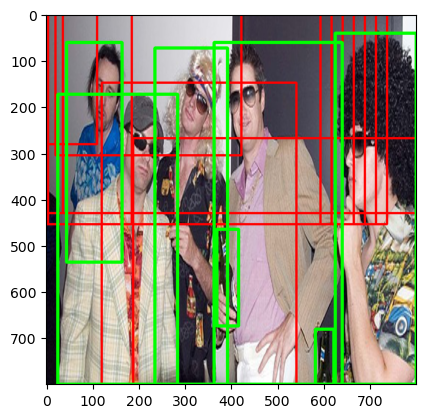

In [98]:
img_clone = np.copy(img_resized)

# draw random anchor boxes
for i in an_rpn_loc_full[index_inside][pos_index]:
    x1 = int(i[0]-i[2]/2)
    y1 = int(i[1]-i[3]/2)
    x2 = int(i[0]+i[2]/2)
    y2 = int(i[1]+i[3]/2)
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bndboxes)):
    cv2.rectangle(img_clone, (int(bndboxes[i][0]), int(bndboxes[i][1])), (int(bndboxes[i][2]), int(bndboxes[i][3])), color=(0, 255, 0), thickness=5)

plt.imshow(img_clone)
plt.show()

In [99]:
def top_n_rank(x,n):
    if type(x)==np.ndarray:
        x=np.ravel(x)
    else: 
        x=np.ravel(x.cpu().data.numpy())
    topn = np.sort(x)[-n-1]
    index = np.where(x>topn)
    topnx = x[index]
    return topnx, index[0]

In [100]:
pred_rpn_loc_xywh = np.array([pred_rpn_loc_x,pred_rpn_loc_y,pred_rpn_loc_w,pred_rpn_loc_h]).T
pred_rpn_loc_xywh.shape

(22500, 4)

In [101]:
def batch_iou(boxes, box):
  lr = np.maximum(
      np.minimum(boxes[:,0]+0.5*boxes[:,2], box[0]+0.5*box[2]) - \
      np.maximum(boxes[:,0]-0.5*boxes[:,2], box[0]-0.5*box[2]),
      0
  )
  tb = np.maximum(
      np.minimum(boxes[:,1]+0.5*boxes[:,3], box[1]+0.5*box[3]) - \
      np.maximum(boxes[:,1]-0.5*boxes[:,3], box[1]-0.5*box[3]),
      0
  )
  inter = lr*tb
  union = boxes[:,2]*boxes[:,3] + box[2]*box[3] - inter
  return inter/union

In [106]:
def nms(boxes, probs, threshold):
  # 내림차순으로 정렬
  order = probs.argsort().cpu().data.numpy()

  # 개수 대로 true 리스트 생성
  keep = [True]*len(order)
 
  
  for i in range(len(order)-1):
    # IOU 검출, 자세한 코드는 하단 batch_iou코드 참조
    ovps = batch_iou(boxes[order[i+1:]], boxes[order[i]])
    for j, ov in enumerate(ovps):
      if ov > threshold:
        # IOU가 특정 threshold 이상인 box를 False로 세팅
        keep[order[j+i+1]] = False
  return keep

In [107]:
k = nms(pred_rpn_loc_xywh,objectness_score,0.7)

C:\Users\c\AppData\Local\Temp\ipykernel_8768\4287147956.py:14: RuntimeWarning: invalid value encountered in divide
  return inter/union


In [109]:
pred_rpn_loc_12000 = pred_rpn_loc_xywh[k]
pred_rpn_loc_12000.shape

(13643, 4)

In [110]:
IOUS_12000, boxes_12000 = ious(pred_rpn_loc_12000,bndboxes)

In [112]:
objectness_score_k = np.array(objectness_score.cpu().data.numpy())[k]

In [113]:
top2000,top2000index = top_n_rank(IOUS_12000,2000)
top2000.shape

(224,)

In [114]:
pred_boxes_2000 = np.array(boxes_12000)[top2000index,0,:]
pred_boxes_2000.shape

(224, 4)

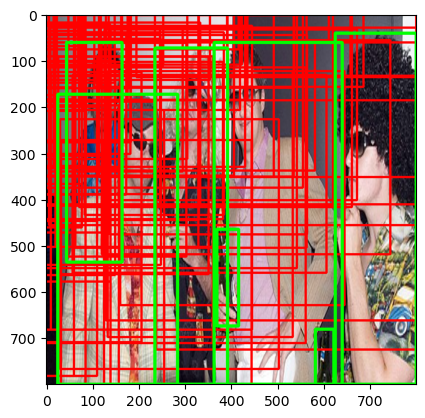

In [115]:
img_clone = np.copy(img_resized)

# draw random anchor boxes
for i in pred_boxes_2000:
    x1 = int(i[0]-i[2]/2)
    y1 = int(i[1]-i[3]/2)
    x2 = int(i[0]+i[2]/2)
    y2 = int(i[1]+i[3]/2)
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes
for i in range(len(bndboxes)):
    cv2.rectangle(img_clone, (int(bndboxes[i][0]), int(bndboxes[i][1])), (int(bndboxes[i][2]), int(bndboxes[i][3])), color=(0, 255, 0), thickness=5)

plt.imshow(img_clone)
plt.show()

## 7. Fast RCNN
- 지금까지 RPN을 통해 선정된 Region Proposal(ROI)들을 이용하여 최종적인 class 분류와 Detection을 실시한다.
- ROI Pooling과 Fast RCNN을 이용한다.
- ROI Pooling은 50* 50 feature map에서 예측된 ROI를 7*7 feature map에 projection 해주는 과정에서 정보의 손실을 최소화 해주기 위하여 고안되었다. 그러나 실제로는 RoI Pooling의 과정에서 소수점이 발생해 반올림을 진행하는 정보의 손실이 발생하는 것은 어쩔 수 없는 과정이었다.
- 이후 7*7 feature map을 펼쳐 Fast RCNN의 FC layer에 통과시킨 뒤, Classifier과 Regressor layer를 통해 Detection이 진행된다.
- 이 과정에서의 Loss는 Fast RCNN 논문에서 제안된 Multi task loss를 이용하며 아래의 수식과 같다.

In [122]:
class RoI_Pooling(nn.Module):
    def __init__(self,output_size):
        super().__init__()
        self.output_size = output_size
        self.maxpool = nn.AdaptiveMaxPool2d(self.output_size)

    def xyxy(self,array):
        arr = np.empty(array.shape)
        
        x1 = array[:,0]-array[:,2]/2
        y1 = array[:,1]-array[:,3]/2
        x2 = array[:,0]+array[:,2]/2
        y2 = array[:,1]+array[:,3]/2
    
        arr[:,0] = x1
        arr[:,1] = y1
        arr[:,2] = x2
        arr[:,3] = y2
        return arr
        
    def forward(self,feature_map,rois):
        pred_roi = self.xyxy(rois)
        #RPN 이 예측한 값에는 float(소수점)이 발생하기 떄문에 quantization(소수점 반올림을 진행한다.)
        ROI = np.clip(np.round(pred_roi/16),0,50).astype(int)

        res=[]
        for i in range(ROI.shape[0]):
            f = feature_map[:,ROI[i][0]:ROI[i][2],ROI[i][1]:ROI[i][3]].unsqueeze(0)
            max_f = self.maxpool(f)
            res.append(max_f)
        res = torch.cat(res,dim=0)
        return res
        

In [123]:
roi_pool = RoI_Pooling(output_size=(7,7))
roi_pool_output = roi_pool(output_map,pred_boxes_2000)

# Reshape the tensor so that we can pass it through the feed forward layer.
k = roi_pool_output.view(roi_pool_output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([224, 25088])


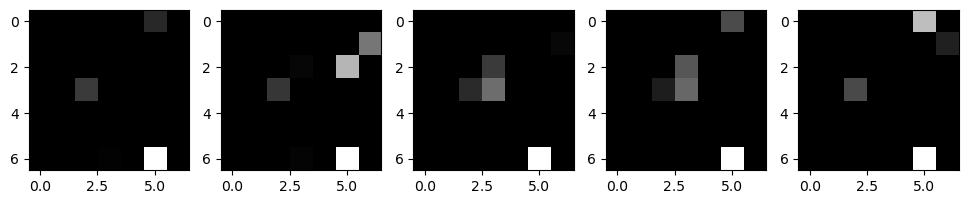

In [131]:
# visualize the first 5 channels of the 50*50*512 feature maps

imgArray = k.view(-1,7,7,512)[0].permute(2,0,1).data.cpu().numpy()
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

In [80]:
# FC layer
class fast_rcnn(nn.Module):
    def __init__(self, class_num=22):
        super().__init__()
        self.class_num = class_num
        self.fc_layer = nn.Sequential(
            nn.Linear(25088,4096),
            nn.Linear(4096,4096)
        )
        self.classify_model = nn.Linear(4096,self.class_num+1)
        self.regression_model = nn.Linear(4096,4*(self.class_num+1))

        self.cls_loss = nn.CrossEntropyLoss()
        self.reg_loss = nn.SmoothL1Loss()

    def forward(self,x):
        x = self.fc_layer(x)
        c = self.classify_model(x)
        r = self.regression_model(x)
        return c,r
'''
    def clac_loss(self,cls_pred,bbox,label,gt_bbox):
        loss_cls = self.cls_loss(cls_pred,label)
        lbl = lables.view(-1,1,1).expand(labels.size(0),1,4)
        mask = (labels !=-0).float().view(-1,1).expand(labels.size(0),4)
        loss_loc = self.sl1(bbox.gather(1, lbl).squeeze(1) * mask, gt_bbox * mask)
        lmb = 1.0
        loss = loss_sc + lmb * loss_loc
        return loss, loss_sc, loss_loc
        '''

'\n    def clac_loss(self,cls_pred,bbox,label,gt_bbox):\n        loss_cls = self.cls_loss(cls_pred,label)\n        '

In [81]:
m = fast_rcnn(20).to(device)
cc,rr = m(k)

In [82]:
print(cc.shape,rr.shape)

torch.Size([2000, 21]) torch.Size([2000, 84])
